# Norway invasive species  

## Data Preprocessing for Machine Learning

In [1]:
import pandas as pd
import numpy as np

# Load the dataset (semicolon-separated, Latin-1 encoded, "NA" as missing values)
df = pd.read_csv("assess.txt", sep=";", encoding="latin1", na_values="NA")

# Drop unnecessary columns (columns 2–6 and the 'Status' column if it exists)
drop_cols = list(df.columns[1:6]) + ["Status"]
df = df.drop(columns=[c for c in drop_cols if c in df.columns])

# Clean up column names: remove extra spaces and replace them with underscores
df.columns = df.columns.str.strip().str.replace(" ", "_")

# Map the 'Impact' column to a numeric scale (so the model can use it)
impact_order = {"NK": 0, "LO": 1, "PH": 2, "HI": 3, "SE": 4}
df["Impact_num"] = df["Impact"].map(impact_order).astype("Int64")

# Helper function to turn comma-separated text fields into 0/1 dummy columns
def make_dummies(df, col, prefix):
    """Convert a comma-separated string column into binary dummy columns."""
    s = df[col].fillna("").astype(str).str.replace(r"\s+", "", regex=True)
    dummies = s.str.get_dummies(sep=",")
    dummies.columns = [f"{prefix}{c}" for c in dummies.columns]
    return dummies

# Create dummy variables for Origin and Current Distribution
origin_dummies = make_dummies(df, "Origin", "Origin_")
curdis_dummies = make_dummies(df, "CurDis", "CurDis_")

# Combine the two pathway columns before encoding (Pathw1 + Pathw2)
path_combined = (
    df[["Pathw1", "Pathw2"]]
    .fillna("")
    .apply(lambda x: ",".join([v for v in x if v]), axis=1)
)

# Create dummy variables for pathways
path_dummies = (
    path_combined
    .str.replace(r"\s+", "", regex=True)
    .str.get_dummies(sep=",")
)
path_dummies.columns = [f"Path_{c}" for c in path_dummies.columns]

# Create dummy variables for lifestyle and ecosystem
life_dummies = make_dummies(df, "LifeSt", "Life_")
eco_dummies = make_dummies(df, "Ecosys", "Eco_")

# Merge all the dummy blocks with the main dataframe
df_ml = pd.concat(
    [df, origin_dummies, curdis_dummies, path_dummies, life_dummies, eco_dummies],
    axis=1
)

# Remove the original text columns (we now have their encoded versions)
df_ml = df_ml.drop(
    columns=["Origin", "CurDis", "Pathw1", "Pathw2", "LifeSt", "Ecosys"],
    errors="ignore"
)

# Replace any remaining missing values with zeros
df_ml = df_ml.fillna(0)

# Print dataset shape and preview the first few rows
print(f"Shape: {df_ml.shape}")
df_ml.head()

Shape: (1532, 217)


,Name,Class,Phylum,Kingd,Mainl,Observ,AOO,Imp12,Impact,minImp,...,Eco_VU-04,Eco_VU-05,Eco_VU-06,Eco_VU-07,Eco_VU-08,Eco_VU-09,Eco_VU-10,Eco_VU-11,Eco_VU-12,Eco_VU-13
0,Abies amabilis,Pinopsida,Pinophyta,Plantae,True,2012.0,40,NR,NK,NK,...,0,0,0,0,0,0,0,0,0,0
1,Abies balsamea,Pinopsida,Pinophyta,Plantae,True,1850.0,512,LO,LO,LO,...,0,0,0,0,0,0,0,0,0,0
2,Abies cephalonica,Pinopsida,Pinophyta,Plantae,True,2005.0,120,NR,LO,LO,...,0,0,0,0,0,0,0,0,0,0
3,Abies concolor,Pinopsida,Pinophyta,Plantae,True,1875.0,1000,PH,PH,LO,...,0,0,0,0,0,0,0,0,0,0
4,Abies grandis,Pinopsida,Pinophyta,Plantae,True,1890.0,240,PH,LO,LO,...,0,0,0,0,0,0,0,0,0,0


## Data visualization and unsupervised exploration

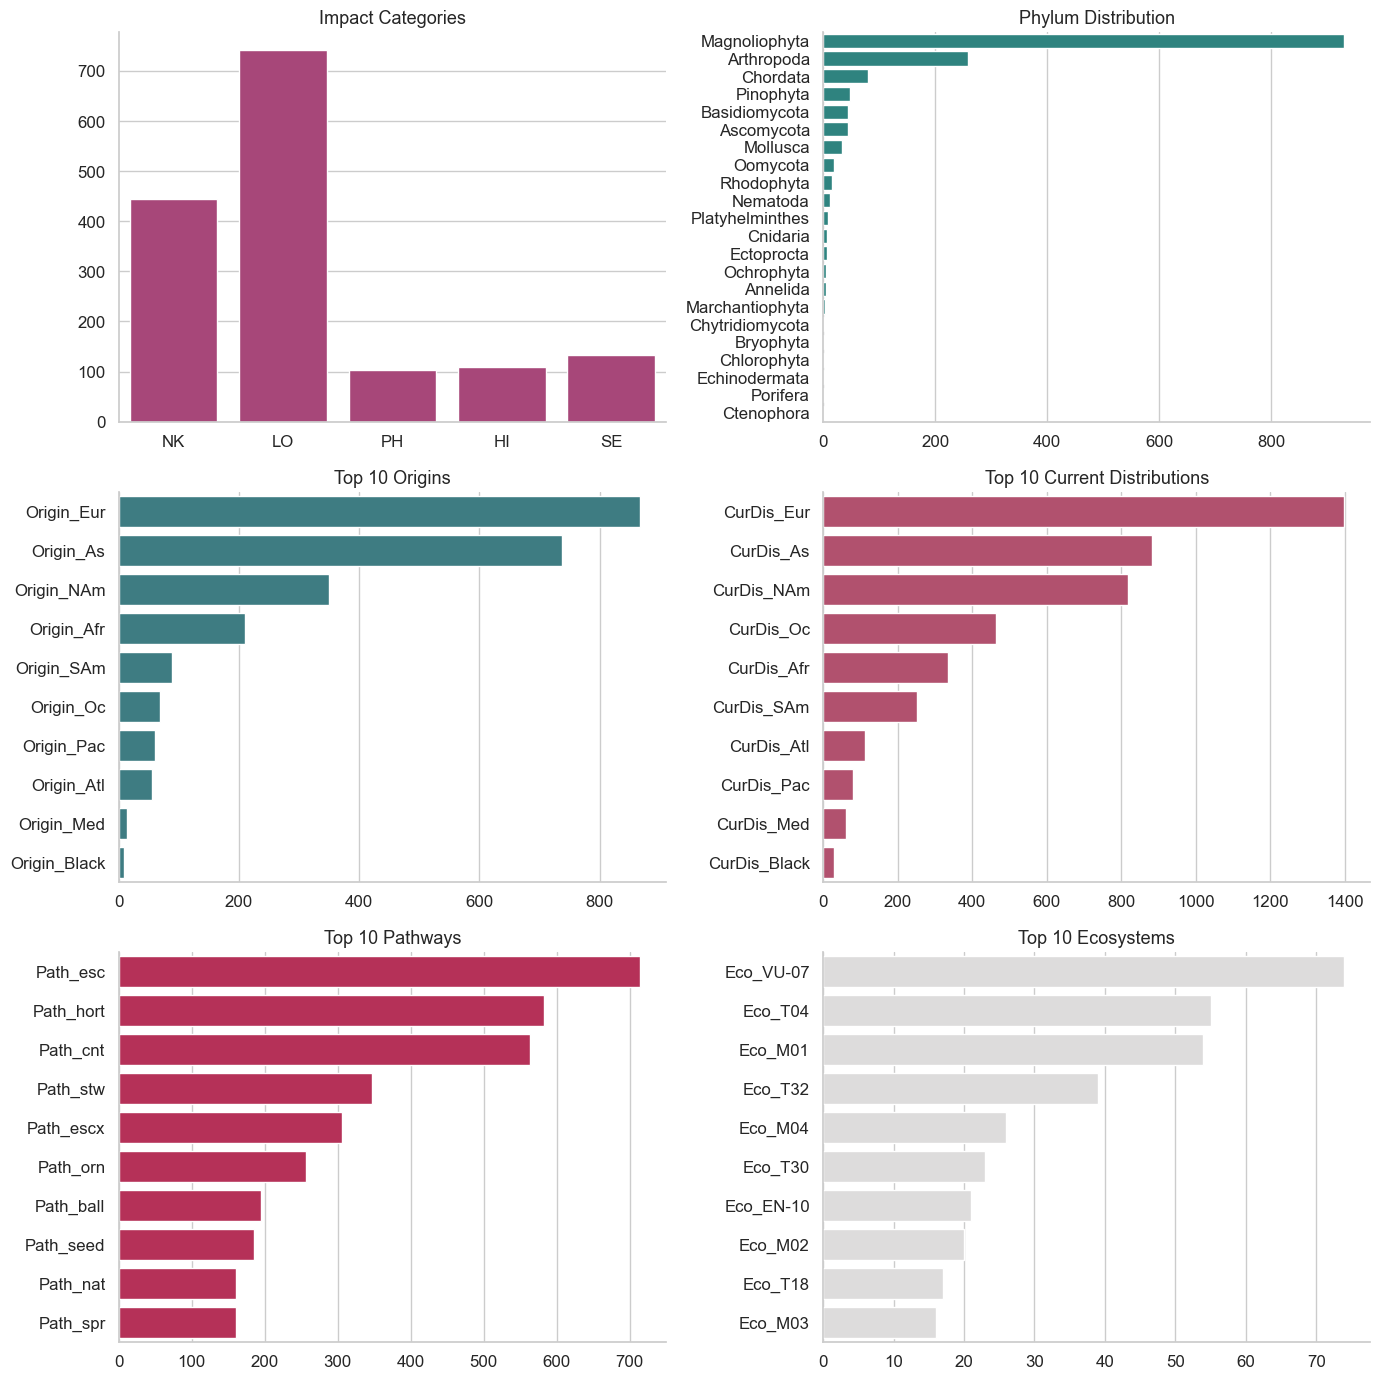

Saved individual panels to: /Users/lucagonella/Documents/Scientific_programming_invasive_species/plots/distribution


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

sns.set(style="whitegrid", font_scale=1.1)

# basic counts we’ll reuse across panels
origin_counts = df_ml.filter(like="Origin_").sum().sort_values(ascending=False)
curdis_counts = df_ml.filter(like="CurDis_").sum().sort_values(ascending=False)
path_counts   = df_ml.filter(like="Path_").sum().sort_values(ascending=False)
life_counts   = df_ml.filter(like="Life_").sum().sort_values(ascending=False)   # kept in case you want it later
eco_counts    = df_ml.filter(like="Eco_").sum().sort_values(ascending=False)
phylum_order  = df_ml["Phylum"].value_counts().index

# pick one color from each palette
COLORS = {
    "impact":  sns.color_palette("magma",   1)[0],
    "phylum":  sns.color_palette("viridis", 1)[0],
    "origins": sns.color_palette("crest",   1)[0],
    "curdis":  sns.color_palette("flare",   1)[0],
    "path":    sns.color_palette("rocket",  1)[0],
    "eco":     sns.color_palette("coolwarm",1)[0],
}

# describe each panel once; we’ll reuse this for both the grid and file outputs
PANEL_SPECS = [
    dict(
        name="impact_categories",
        title="Impact Categories",
        draw=lambda ax: sns.countplot(
            data=df_ml, x="Impact",
            order=["NK", "LO", "PH", "HI", "SE"],
            color=COLORS["impact"], ax=ax),
    ),
    dict(
        name="phylum_distribution",
        title="Phylum Distribution",
        draw=lambda ax: sns.countplot(
            data=df_ml, y="Phylum",
            order=phylum_order,
            color=COLORS["phylum"], ax=ax),
    ),
    dict(
        name="top10_origins",
        title="Top 10 Origins",
        draw=lambda ax: sns.barplot(
            x=origin_counts.head(10), y=origin_counts.head(10).index,
            color=COLORS["origins"], ax=ax),
    ),
    dict(
        name="top10_curdis",
        title="Top 10 Current Distributions",
        draw=lambda ax: sns.barplot(
            x=curdis_counts.head(10), y=curdis_counts.head(10).index,
            color=COLORS["curdis"], ax=ax),
    ),
    dict(
        name="top10_pathways",
        title="Top 10 Pathways",
        draw=lambda ax: sns.barplot(
            x=path_counts.head(10), y=path_counts.head(10).index,
            color=COLORS["path"], ax=ax),
    ),
    dict(
        name="top10_ecosystems",
        title="Top 10 Ecosystems",
        draw=lambda ax: sns.barplot(
            x=eco_counts.head(10), y=eco_counts.head(10).index,
            color=COLORS["eco"], ax=ax),
    ),
]

def prettify(ax):
    """Minor cleanup so all plots look consistent."""
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

# 1) show a 3×2 overview grid in the notebook
fig, axes = plt.subplots(3, 2, figsize=(14, 14))
axes = axes.ravel()

for spec, ax in zip(PANEL_SPECS, axes):
    spec["draw"](ax)
    ax.set_title(spec["title"], fontsize=13)
    prettify(ax)

plt.tight_layout()
plt.show()

# 2) also save each panel as its own figure (handy for slides)
out_dir = Path("plots") / "distribution"
out_dir.mkdir(parents=True, exist_ok=True)

for spec in PANEL_SPECS:
    fig, ax = plt.subplots(figsize=(7.5, 5.5))  # slide-friendly size
    spec["draw"](ax)
    ax.set_title(spec["title"], fontsize=14)
    prettify(ax)
    fig.tight_layout()
    fig.savefig(out_dir / f"{spec['name']}.png", dpi=300, bbox_inches="tight")
    fig.savefig(out_dir / f"{spec['name']}.svg",            bbox_inches="tight")
    plt.close(fig)

print(f"Saved individual panels to: {out_dir.resolve()}")

/opt/anaconda3/envs/scientific_programming_project/lib/python3.10/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:258: RuntimeWarning: The result contains negative eigenvalues that are large in magnitude, which may suggest result inaccuracy. See Notes for details. The negative-most eigenvalue is -4.421202308589213 whereas the largest positive one is 187.05660070400637.
  warn(
/opt/anaconda3/envs/scientific_programming_project/lib/python3.10/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:258: RuntimeWarning: The result contains negative eigenvalues that are large in magnitude, which may suggest result inaccuracy. See Notes for details. The negative-most eigenvalue is -10.052866106839522 whereas the largest positive one is 181.53862911274783.
  warn(
/opt/anaconda3/envs/scientific_programming_project/lib/python3.10/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:258: RuntimeWarning: The result contains negative eigenv

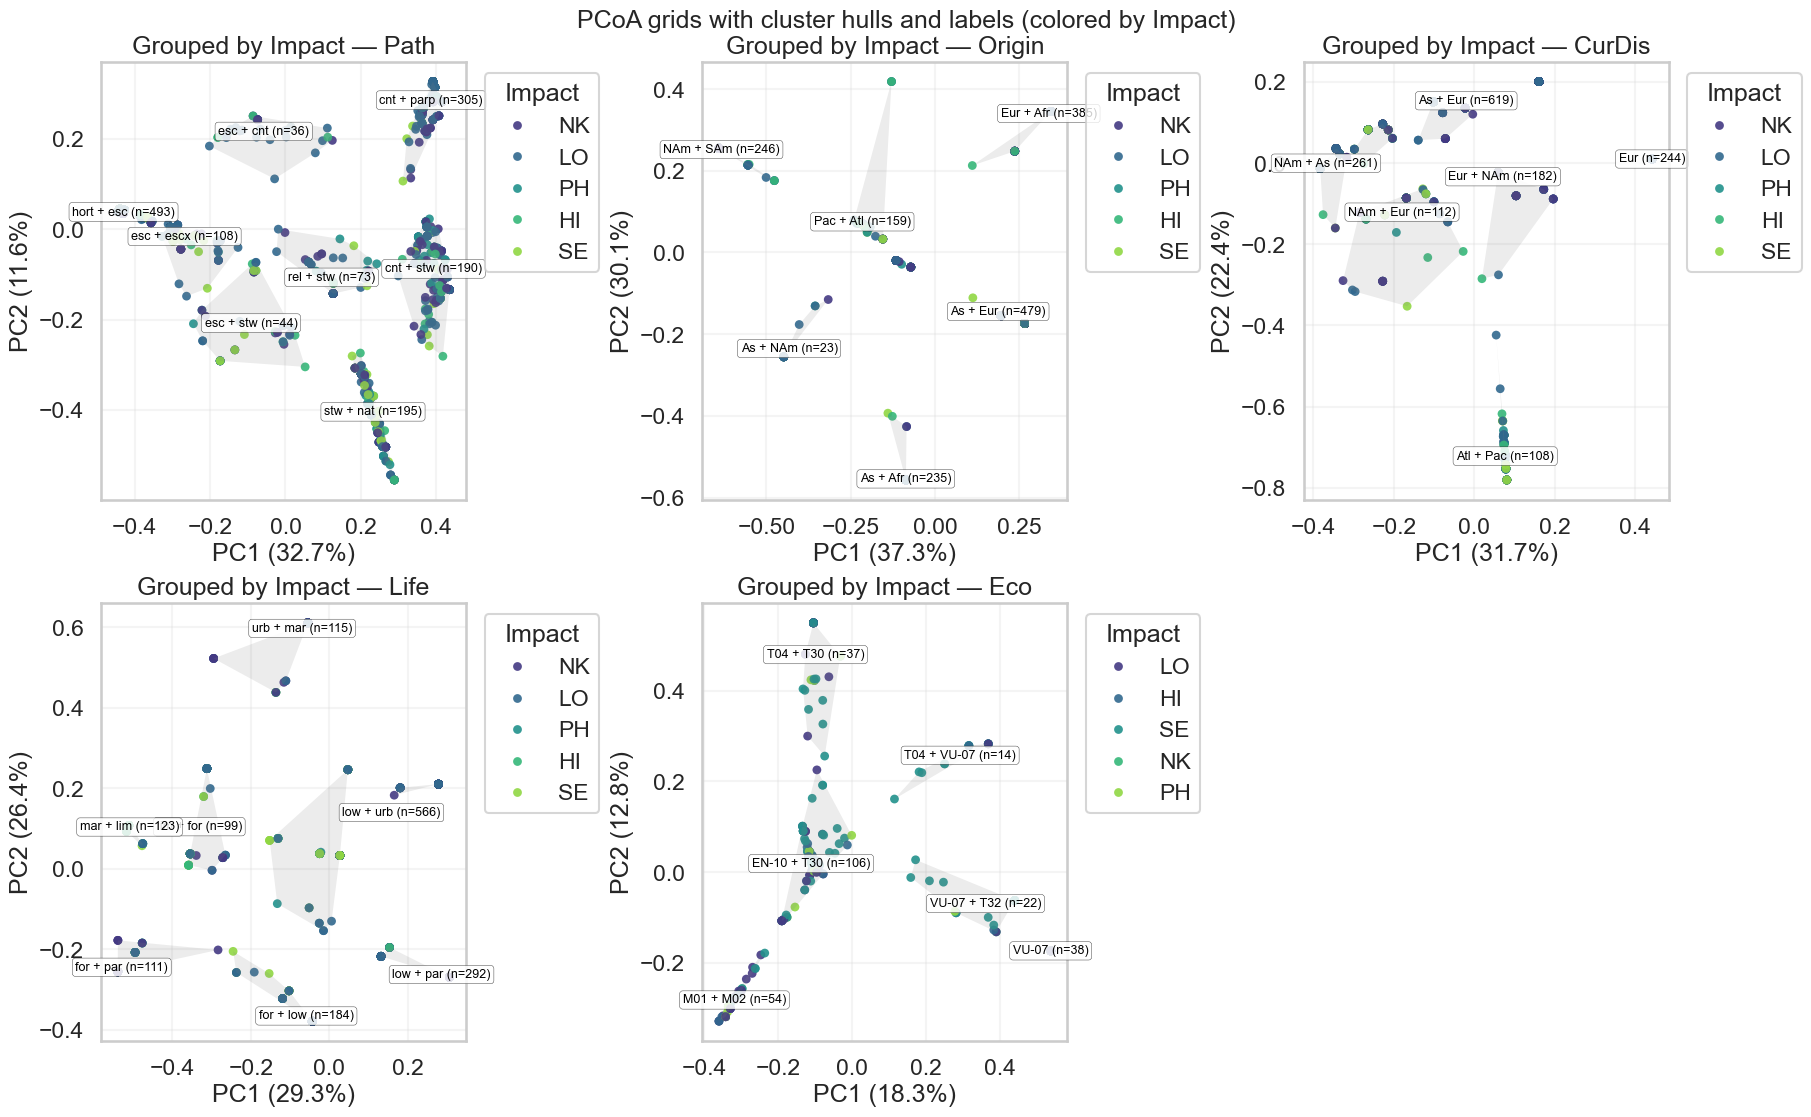

/opt/anaconda3/envs/scientific_programming_project/lib/python3.10/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:258: RuntimeWarning: The result contains negative eigenvalues that are large in magnitude, which may suggest result inaccuracy. See Notes for details. The negative-most eigenvalue is -4.421202308589213 whereas the largest positive one is 187.05660070400637.
  warn(
/opt/anaconda3/envs/scientific_programming_project/lib/python3.10/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:258: RuntimeWarning: The result contains negative eigenvalues that are large in magnitude, which may suggest result inaccuracy. See Notes for details. The negative-most eigenvalue is -10.052866106839522 whereas the largest positive one is 181.53862911274783.
  warn(
/opt/anaconda3/envs/scientific_programming_project/lib/python3.10/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:258: RuntimeWarning: The result contains negative eigenv

Saved single-panel PCoA figures to: /Users/lucagonella/Documents/Scientific_programming_invasive_species/plots/pcoa


In [6]:
from sklearn.metrics import pairwise_distances, silhouette_score
from sklearn.cluster import KMeans
from skbio.stats.ordination import pcoa
from skbio import DistanceMatrix
from scipy.spatial import ConvexHull, QhullError

sns.set_context("talk")

# Folder where individual PCoA plots will be saved
OUT_DIR = Path("plots/pcoa")
OUT_DIR.mkdir(parents=True, exist_ok=True)


def _block_matrix(df: pd.DataFrame, prefix: str) -> pd.DataFrame:
    """
    Selects all columns that belong to a given dummy variable block (e.g., "Path_", "Eco_"),
    converts them to binary (0/1), and removes empty rows or columns.

    Returns a clean binary matrix that can be used for distance calculations.
    """
    cols = [c for c in df.columns if c.startswith(prefix)]
    X = df[cols].fillna(0).astype(int).clip(0, 1)
    X = X.loc[X.any(axis=1)]        # remove rows that have only zeros
    X = X.loc[:, X.any(axis=0)]     # remove columns that have only zeros
    return X


def _pcoa_jaccard(X: pd.DataFrame):
    """
    Performs Principal Coordinates Analysis (PCoA) using the Jaccard distance metric.

    The function computes pairwise dissimilarities between all samples (rows),
    applies PCoA, and returns both:
    - coordinates (first two principal axes)
    - percentage of variance explained by PC1 and PC2
    """
    # Compute Jaccard distance between binary vectors
    D = pairwise_distances(X.values.astype(bool), metric="jaccard")
    dm = DistanceMatrix(D, ids=X.index.astype(str).tolist())

    # Perform PCoA and extract the first two components
    p = pcoa(dm)
    coords = p.samples.iloc[:, :2].copy()
    coords.columns = ["PC1", "PC2"]

    # Extract explained variance for labeling the axes
    vx = float(p.proportion_explained["PC1"] * 100)
    vy = float(p.proportion_explained["PC2"] * 100)
    return coords, (vx, vy)


def _best_k(coords: pd.DataFrame, k_range=range(2, 9), random_state=42):
    """
    Automatically selects the optimal number of clusters (k) based on silhouette score.

    The function runs K-Means for several k values, evaluates the silhouette score
    for each, and chooses the one that best captures cluster separation in the PCoA space.
    """
    X = coords[["PC1", "PC2"]].to_numpy()
    best_k, best_s = None, -1

    for k in k_range:
        km = KMeans(n_clusters=k, n_init=10, random_state=random_state).fit(X)
        s = silhouette_score(X, km.labels_)
        if s > best_s:
            best_k, best_s = k, s

    # Refit with the optimal k for final cluster assignment
    labels = KMeans(n_clusters=best_k, n_init=20, random_state=random_state).fit(X).labels_
    return labels, best_k, best_s


def _top_feature_labels(X_block: pd.DataFrame, labels, top_k=2):
    """
    Identifies the most characteristic features for each cluster.

    For each cluster:
    - Computes the mean value of every feature (0–1 columns)
    - Keeps the top_k features with the highest mean occurrence
    - Returns human-readable labels like "cnt + stw" for easy interpretation
    """
    labnames, labels = {}, np.asarray(labels)

    for cl in np.unique(labels):
        mu = X_block.loc[X_block.index[labels == cl]].mean().sort_values(ascending=False)
        mu = mu[mu > 0]
        if mu.empty:
            labnames[cl] = "(no signal)"
            continue

        feats = mu.index[:top_k].tolist()
        nice = [f.split("_", 1)[1].replace("_", " ") if "_" in f else f for f in feats]
        labnames[cl] = " + ".join(nice)

    return labnames


def _fill_hulls(ax, coords: pd.DataFrame, labels, color="grey", alpha=0.15):
    """
    Adds soft convex hulls around clusters to visualize their boundaries.
    Skips groups with fewer than 3 points or degenerate geometry.
    """
    labels = pd.Series(labels, index=coords.index, name="cluster")

    for _, grp in coords.join(labels).groupby("cluster"):
        if len(grp) < 3:
            continue
        try:
            pts = grp[["PC1", "PC2"]].to_numpy()
            hull = ConvexHull(pts)
            poly = pts[hull.vertices]
            ax.fill(poly[:, 0], poly[:, 1], color=color, alpha=alpha, linewidth=0)
        except QhullError:
            pass


def draw_pcoa_panel(
    df: pd.DataFrame,
    prefix: str,
    hue_col: str = "Impact",
    palette: str = "viridis",
    title_prefix: str | None = "Grouped by Impact —",
    ax: plt.Axes | None = None,
):
    """
    Creates a single PCoA plot for a specific feature block (e.g., Path_, Origin_, etc.).

    Steps:
    1. Extract the binary block for the selected prefix
    2. Run PCoA on Jaccard distances to visualize sample similarity
    3. Automatically cluster samples and name clusters by key features
    4. Plot the PCoA points colored by the given hue (e.g., Impact)
    5. Add cluster hulls and centroid labels

    Returns:
        fig, meta
        - fig: the matplotlib figure object
        - meta: metadata including coordinates, cluster labels, variance, etc.
    """
    # Extract binary matrix for this category
    X = _block_matrix(df, prefix)
    if X.shape[0] < 5 or X.shape[1] < 2:
        raise ValueError(f"Not enough data after filtering for '{prefix}'.")

    # Compute ordination (2D coordinates) and variance explained
    coords, (vx, vy) = _pcoa_jaccard(X)

    # Add the hue column (Impact) for coloring
    plot_df = coords.copy()
    plot_df[hue_col] = df.loc[X.index, hue_col].astype(str).values

    # Cluster points in PCoA space
    labels, k, sil = _best_k(coords)
    labnames = _top_feature_labels(X, labels, top_k=2)

    # Compute cluster centroids for labeling
    lab_series = pd.Series([labnames[cl] for cl in labels], index=coords.index, name="label")
    centroids = coords.join(lab_series).groupby("label")[["PC1", "PC2"]].mean()
    sizes = lab_series.value_counts()

    # Create plot if no existing axis is provided
    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 6))
    else:
        fig = ax.figure

    # Scatterplot colored by Impact
    sns.scatterplot(
        ax=ax, data=plot_df, x="PC1", y="PC2",
        hue=hue_col, palette=palette, s=40, alpha=0.9, edgecolor="none"
    )

    # Draw soft cluster hulls
    _fill_hulls(ax, coords, labels, color="grey", alpha=0.15)

    # Add text labels at cluster centroids
    for lab, (x, y) in centroids.iterrows():
        ax.text(
            x, y, f"{lab} (n={sizes[lab]})",
            ha="center", va="center", fontsize=9, color="black",
            bbox=dict(boxstyle="round,pad=0.25", fc="white", ec="black", lw=0.3, alpha=0.85),
        )

    # Titles and labels
    blk = prefix.rstrip("_")
    title = f"PCoA (Jaccard) — {blk}"
    if title_prefix:
        title = f"{title_prefix} {blk}"
    ax.set_title(title)
    ax.set_xlabel(f"PC1 ({vx:.1f}%)")
    ax.set_ylabel(f"PC2 ({vy:.1f}%)")
    ax.legend(title=hue_col, loc="upper left", bbox_to_anchor=(1.02, 1))
    ax.grid(True, alpha=0.2)

    meta = dict(coords=coords, labels=labels, cluster_names=labnames, k=k, sil=sil, var=(vx, vy))
    return fig, meta


# Show a grid with all PCoA plots together
blocks = ["Path_", "Origin_", "CurDis_", "Life_", "Eco_"]

ncols = 3
nrows = int(np.ceil(len(blocks) / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(6 * ncols, 5.4 * nrows), constrained_layout=True)
axes = axes.ravel()

# Generate one panel per feature category
for i, prefix in enumerate(blocks):
    draw_pcoa_panel(df_ml, prefix, hue_col="Impact", palette="viridis", title_prefix="Grouped by Impact —", ax=axes[i])

# Hide any unused empty subplots
for ax in axes[len(blocks):]:
    ax.axis("off")

fig.suptitle("PCoA grids with cluster hulls and labels (colored by Impact)", y=1.02, fontsize=18)
plt.show()


# Save each PCoA panel separately for use in slides or reports
for prefix in blocks:
    fig_i, _ = draw_pcoa_panel(df_ml, prefix, hue_col="Impact", palette="viridis", title_prefix="Grouped by Impact —")
    out = OUT_DIR / f"pcoa_{prefix.rstrip('_').lower()}_impact.png"
    fig_i.savefig(out, dpi=300, bbox_inches="tight")
    plt.close(fig_i)

print(f"Saved single-panel PCoA figures to: {OUT_DIR.resolve()}")

Generating: uRF proximity — Path → urf_heatmap_path.png


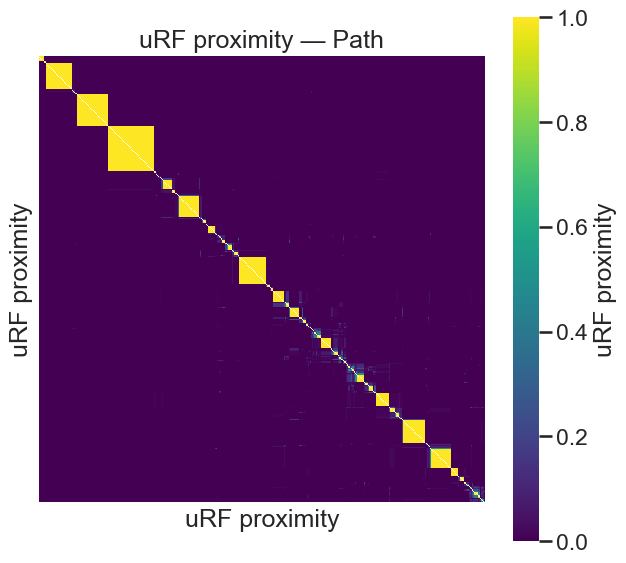

Generating: uRF proximity — Origin → urf_heatmap_origin.png


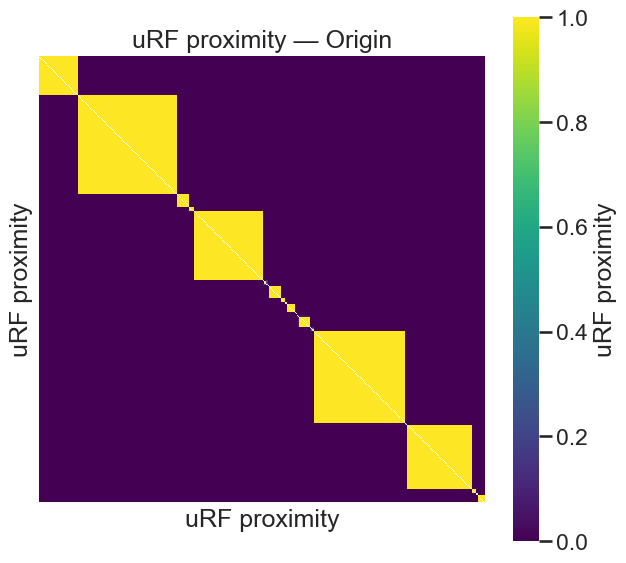

Generating: uRF proximity — CurDis → urf_heatmap_curdis.png


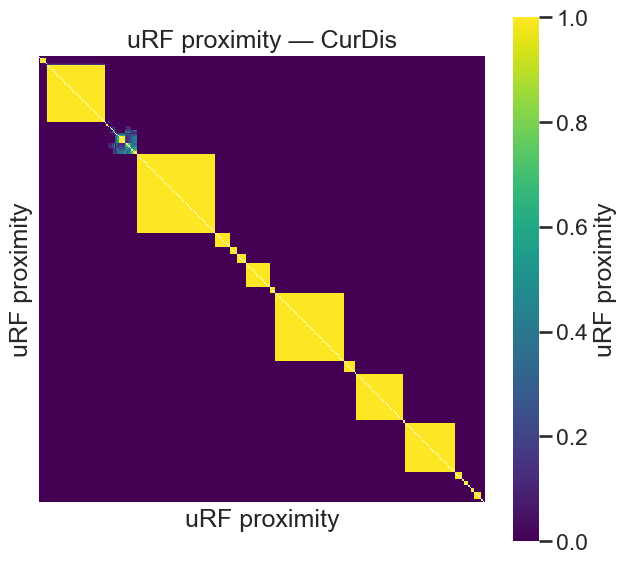

Generating: uRF proximity — Life → urf_heatmap_life.png


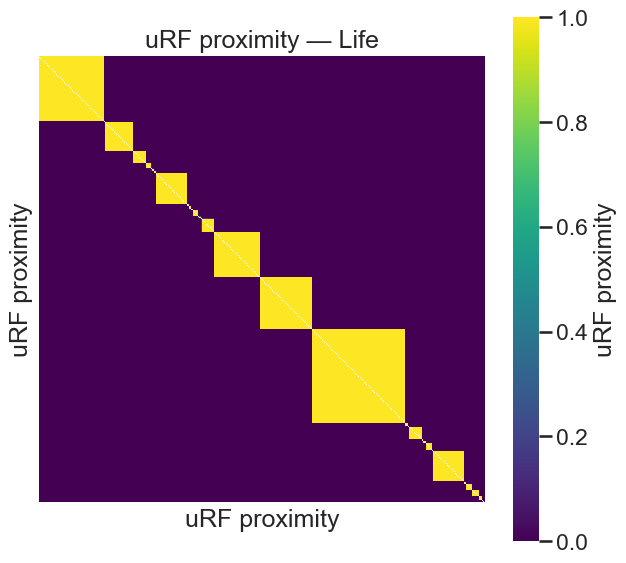

Generating: uRF proximity — Eco → urf_heatmap_eco.png


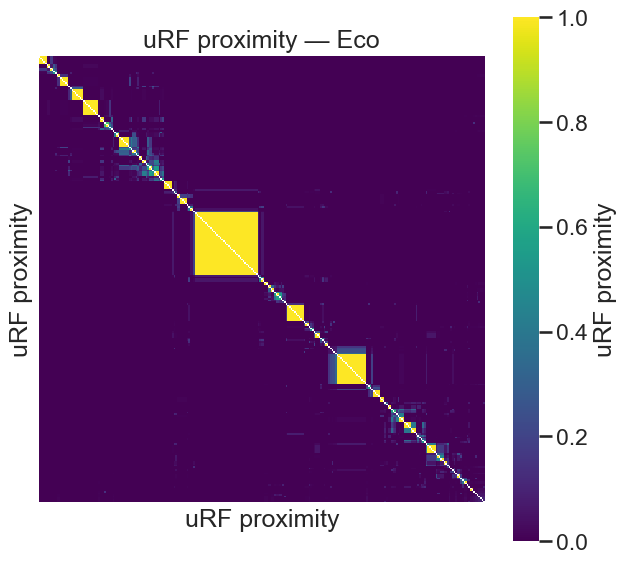

Generating: uRF proximity — All dummies → urf_heatmap_all_dummies.png


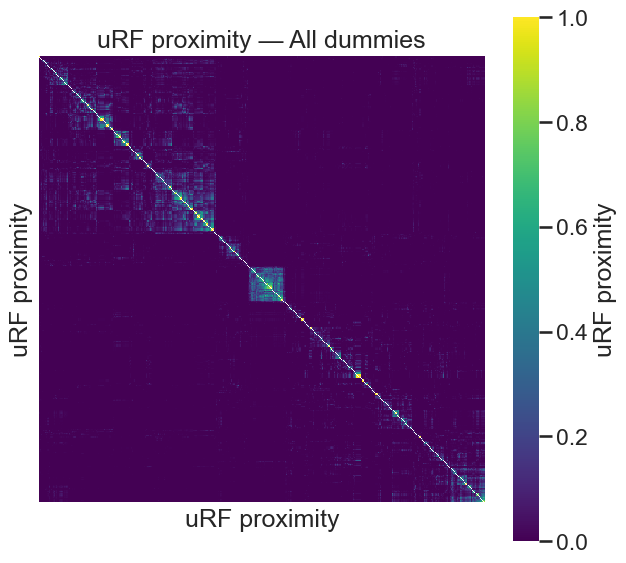

In [19]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from scipy.cluster.hierarchy import linkage, leaves_list
from matplotlib import gridspec

sns.set_context("talk")


# 1) pick the dummy block we want to compare (e.g., "Path_", "Origin_", ...)
def select_block(df, prefix_or_prefixes):
    """Return a clean 0/1 matrix for the requested dummy block(s)."""
    prefixes = [prefix_or_prefixes] if isinstance(prefix_or_prefixes, str) else prefix_or_prefixes
    cols = [c for c in df.columns if any(c.startswith(p) for p in prefixes)]
    X = df[cols].fillna(0).astype(int).clip(0, 1)
    X = X.loc[X.any(axis=1)]           # drop all-zero rows
    X = X.loc[:, X.any(axis=0)]        # drop all-zero columns
    return X


# 2) unsupervised RF proximity (Breiman trick)
def urf_proximity(X, n_trees=1800, seed=42):
    """Return an (n x n) proximity matrix in a DataFrame indexed like X."""
    n = len(X)
    rng = np.random.default_rng(seed)

    X_noise = X.apply(lambda col: rng.permutation(col.values))
    X_mix = pd.concat([X, X_noise], axis=0).values
    y = np.r_[np.ones(n, dtype=int), np.zeros(n, dtype=int)]

    rf = RandomForestClassifier(
        n_estimators=n_trees, max_features="sqrt",
        min_samples_leaf=1, n_jobs=-1, random_state=seed
    ).fit(X_mix, y)

    leaves = [est.apply(X.values) for est in rf.estimators_]
    prox = np.zeros((n, n), dtype=np.float32)
    for leaf in leaves:
        prox += (leaf[:, None] == leaf[None, :])
    prox /= float(n_trees)
    np.fill_diagonal(prox, 1.0)

    return pd.DataFrame(prox, index=X.index, columns=X.index)


# 3) simple, interpretable heatmap (no extra color strips)
def plot_urf_heatmap(
    X, *, title="", max_n=500, cmap="viridis", figsize=(7.2, 6.8), save_to=None, seed=123
):
    """
    X: 0/1 block (rows = samples). Computes uRF proximity, clusters, and plots a clean heatmap.
    max_n: optional downsampling for very large n (random, but with a fixed seed).
    save_to: optional Path to save the figure (PNG/SVG, etc.).
    """
    # compute proximity
    P = urf_proximity(X, n_trees=1800, seed=seed)

    # optional downsample to keep the plot readable
    n = P.shape[0]
    if n > max_n:
        rng = np.random.default_rng(seed)
        keep = np.sort(rng.choice(n, size=max_n, replace=False))
        P = P.iloc[keep, keep]

    # cluster order (average linkage on distance = 1 - proximity)
    D = 1.0 - P.to_numpy()
    Z = linkage(D[np.triu_indices_from(D, 1)], method="average")
    order = leaves_list(Z)
    P = P.iloc[order, order]

    # mask diagonal; square cells; clean frame
    mask = np.eye(P.shape[0], dtype=bool)

    plt.figure(figsize=figsize)
    ax = sns.heatmap(
        P, mask=mask, cmap=cmap, vmin=0, vmax=1, square=True,
        xticklabels=False, yticklabels=False,
        cbar_kws=dict(label="uRF proximity")
    )
    ax.set_title(title)
    ax.set_xlabel("uRF proximity")
    ax.set_ylabel("uRF proximity")
    ax.collections[0].set_rasterized(True)  # crisper exports for slides

    if save_to:
        Path(save_to).parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(save_to, dpi=300, bbox_inches="tight")
    plt.show()

    # Define the blocks you want to plot
blocks = [
    ("Path_", "uRF proximity — Path"),
    ("Origin_", "uRF proximity — Origin"),
    ("CurDis_", "uRF proximity — CurDis"),
    ("Life_", "uRF proximity — Life"),
    ("Eco_", "uRF proximity — Eco"),
    (["Path_", "Origin_", "CurDis_", "Life_", "Eco_"], "uRF proximity — All dummies")
]

# Directory where all heatmaps will be saved
SAVE_DIR = Path("plots/urf_heatmaps")
SAVE_DIR.mkdir(parents=True, exist_ok=True)

# Generate and save each heatmap
for prefixes, title in blocks:
    X_block = select_block(df_ml, prefixes)
    # create a short file-friendly name (e.g. "urf_heatmap_path.png")
    name = prefixes if isinstance(prefixes, str) else "all_dummies"
    out_path = SAVE_DIR / f"urf_heatmap_{str(name).rstrip('_').lower()}.png"

    print(f"Generating: {title} → {out_path.name}")
    plot_urf_heatmap(
        X_block,
        title=title,
        max_n=500,
        cmap="viridis",
        save_to=out_path
    )


## Building XGBoost model

In [20]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

# Convert Impact to numeric (if categorical)
impact_map = {'NK': 0, 'LO': 1, 'PH': 2, 'HI': 3, 'SE': 4}
df_ml["Impact_num"] = df_ml["Impact"].map(impact_map)

# X = all dummy variables
X = df_ml[[c for c in df_ml.columns if any(c.startswith(p) for p in ["Path_", "Origin_", "CurDis_", "Life_", "Eco_"])]]
y = df_ml["Impact_num"]

# Split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123, stratify=y.round())

In [21]:
model = xgb.XGBRegressor( # building the model, using usual parameters
    n_estimators=1000,
    learning_rate=0.03,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=123,
    tree_method="hist"
)
model.fit(X_train, y_train) #training model

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None
,feature_types,None


R² = 0.394, RMSE = 0.919


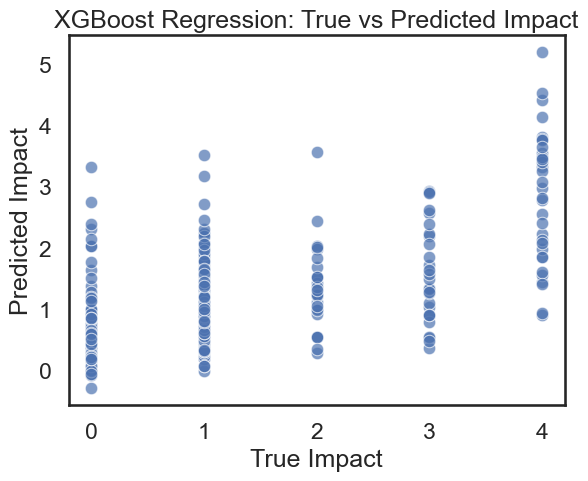

In [22]:
# predicting impact using test set
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"R² = {r2:.3f}, RMSE = {rmse:.3f}") 

sns.scatterplot(x=y_test, y=y_pred, alpha=0.7)
plt.xlabel("True Impact")
plt.ylabel("Predicted Impact")
plt.title("XGBoost Regression: True vs Predicted Impact")
plt.show()

In [25]:
# Assign higher weights to rare, high-impact classes, class imbalance ==> check distribution plots
weights = y_train.map({0:0.8, 1:0.5, 2:1.5, 3:1.3, 4:1.3})
model.fit(X_train, y_train, sample_weight=weights) #re-train using weights

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None
,feature_types,None


R² = 0.356, RMSE = 0.947


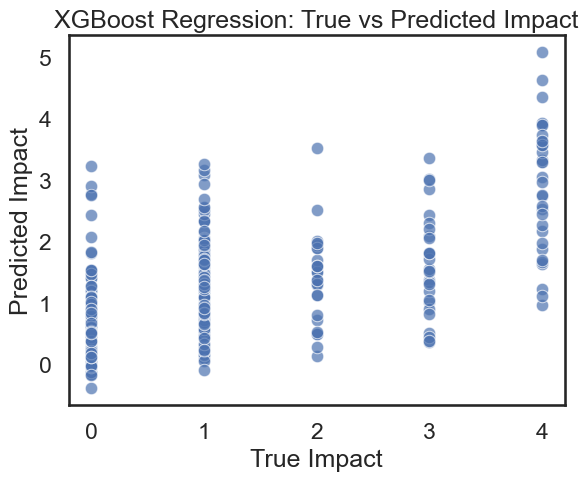

In [26]:
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"R² = {r2:.3f}, RMSE = {rmse:.3f}")

sns.scatterplot(x=y_test, y=y_pred, alpha=0.7)
plt.xlabel("True Impact")
plt.ylabel("Predicted Impact")
plt.title("XGBoost Regression: True vs Predicted Impact")
plt.show()

even worse, let's try parameter optimizaton 

[I 2025-10-17 10:15:48,894] A new study created in memory with name: no-name-9fd0a6eb-932c-4807-ad4f-54c332440e20
Best trial: 0. Best value: 0.984855:   1%|▏         | 1/80 [00:00<00:54,  1.45it/s]

[I 2025-10-17 10:15:49,585] Trial 0 finished with value: 0.9848546570082083 and parameters: {'n_estimators': 650, 'max_depth': 4, 'learning_rate': 0.16931783077832116, 'subsample': 0.8941013037812033, 'colsample_bytree': 0.8156400609456731, 'reg_lambda': 5.191680347896293, 'reg_alpha': 0.49005183579348766, 'min_child_weight': 6}. Best is trial 0 with value: 0.9848546570082083.


Best trial: 0. Best value: 0.984855:   2%|▎         | 2/80 [00:03<02:28,  1.90s/it]

[I 2025-10-17 10:15:52,339] Trial 1 finished with value: 1.030896559749661 and parameters: {'n_estimators': 1821, 'max_depth': 7, 'learning_rate': 0.05536385608995721, 'subsample': 0.8455992055034849, 'colsample_bytree': 0.9352675050025326, 'reg_lambda': 0.1633656501755585, 'reg_alpha': 0.49551625048001313, 'min_child_weight': 5}. Best is trial 0 with value: 0.9848546570082083.


Best trial: 0. Best value: 0.984855:   4%|▍         | 3/80 [00:04<02:05,  1.63s/it]

[I 2025-10-17 10:15:53,651] Trial 2 finished with value: 1.0252345375061487 and parameters: {'n_estimators': 641, 'max_depth': 10, 'learning_rate': 0.16168909288473, 'subsample': 0.9451558195331545, 'colsample_bytree': 0.9850584992916684, 'reg_lambda': 4.553979808638151, 'reg_alpha': 0.5982709040713542, 'min_child_weight': 1}. Best is trial 0 with value: 0.9848546570082083.


Best trial: 0. Best value: 0.984855:   5%|▌         | 4/80 [00:05<01:48,  1.43s/it]

[I 2025-10-17 10:15:54,775] Trial 3 finished with value: 1.07409484148654 and parameters: {'n_estimators': 992, 'max_depth': 5, 'learning_rate': 0.28524830278192936, 'subsample': 0.7790149087152419, 'colsample_bytree': 0.7840547317488157, 'reg_lambda': 0.8667904280574831, 'reg_alpha': 0.5569000064160919, 'min_child_weight': 6}. Best is trial 0 with value: 0.9848546570082083.


Best trial: 4. Best value: 0.956575:   6%|▋         | 5/80 [00:07<02:02,  1.64s/it]

[I 2025-10-17 10:15:56,779] Trial 4 finished with value: 0.9565754953552851 and parameters: {'n_estimators': 1363, 'max_depth': 7, 'learning_rate': 0.026054547297742085, 'subsample': 0.8536986683993217, 'colsample_bytree': 0.8101679386771838, 'reg_lambda': 0.11445765530337967, 'reg_alpha': 0.8398676125677883, 'min_child_weight': 5}. Best is trial 4 with value: 0.9565754953552851.


Best trial: 4. Best value: 0.956575:   8%|▊         | 6/80 [00:08<01:46,  1.44s/it]

[I 2025-10-17 10:15:57,843] Trial 5 finished with value: 1.0173116324019642 and parameters: {'n_estimators': 532, 'max_depth': 10, 'learning_rate': 0.12642160432914126, 'subsample': 0.7347192282784847, 'colsample_bytree': 0.8172374867221466, 'reg_lambda': 1.3961064997362553, 'reg_alpha': 0.5678636347506205, 'min_child_weight': 8}. Best is trial 4 with value: 0.9565754953552851.


Best trial: 4. Best value: 0.956575:   9%|▉         | 7/80 [00:10<01:54,  1.56s/it]

[I 2025-10-17 10:15:59,653] Trial 6 finished with value: 1.0030973864405988 and parameters: {'n_estimators': 905, 'max_depth': 10, 'learning_rate': 0.07227903960890242, 'subsample': 0.9146452817556199, 'colsample_bytree': 0.7812549805566722, 'reg_lambda': 2.429361283060538, 'reg_alpha': 0.8143553524091448, 'min_child_weight': 6}. Best is trial 4 with value: 0.9565754953552851.


Best trial: 4. Best value: 0.956575:  10%|█         | 8/80 [00:11<01:36,  1.34s/it]

[I 2025-10-17 10:16:00,526] Trial 7 finished with value: 0.9753048848029344 and parameters: {'n_estimators': 734, 'max_depth': 5, 'learning_rate': 0.11611847020656674, 'subsample': 0.8061982771780146, 'colsample_bytree': 0.9344780725585042, 'reg_lambda': 0.779001352007864, 'reg_alpha': 0.5618546211154146, 'min_child_weight': 2}. Best is trial 4 with value: 0.9565754953552851.


Best trial: 4. Best value: 0.956575:  11%|█▏        | 9/80 [00:13<01:54,  1.61s/it]

[I 2025-10-17 10:16:02,722] Trial 8 finished with value: 1.086105992260963 and parameters: {'n_estimators': 1642, 'max_depth': 6, 'learning_rate': 0.17250040751266285, 'subsample': 0.7744211684047978, 'colsample_bytree': 0.6812217506599908, 'reg_lambda': 0.5728731762060564, 'reg_alpha': 0.7105896424646752, 'min_child_weight': 6}. Best is trial 4 with value: 0.9565754953552851.


Best trial: 9. Best value: 0.912673:  12%|█▎        | 10/80 [00:14<01:39,  1.42s/it]

[I 2025-10-17 10:16:03,705] Trial 9 finished with value: 0.9126725347261542 and parameters: {'n_estimators': 505, 'max_depth': 10, 'learning_rate': 0.012949754661151327, 'subsample': 0.9710041768678835, 'colsample_bytree': 0.6742987911500419, 'reg_lambda': 6.278803893142588, 'reg_alpha': 0.44402456379835975, 'min_child_weight': 4}. Best is trial 9 with value: 0.9126725347261542.


Best trial: 10. Best value: 0.90949:  14%|█▍        | 11/80 [00:16<01:51,  1.61s/it]

[I 2025-10-17 10:16:05,765] Trial 10 finished with value: 0.909489956698086 and parameters: {'n_estimators': 1243, 'max_depth': 8, 'learning_rate': 0.010655599758431536, 'subsample': 0.6099555055918041, 'colsample_bytree': 0.6049095613577771, 'reg_lambda': 9.457944591727856, 'reg_alpha': 0.1873367206394458, 'min_child_weight': 3}. Best is trial 10 with value: 0.909489956698086.


Best trial: 10. Best value: 0.90949:  15%|█▌        | 12/80 [00:19<02:00,  1.77s/it]

[I 2025-10-17 10:16:07,906] Trial 11 finished with value: 0.9102975956606487 and parameters: {'n_estimators': 1320, 'max_depth': 8, 'learning_rate': 0.01001797008244537, 'subsample': 0.6203768455945411, 'colsample_bytree': 0.6041734106869494, 'reg_lambda': 8.765382485206088, 'reg_alpha': 0.1702597647359125, 'min_child_weight': 3}. Best is trial 10 with value: 0.909489956698086.


Best trial: 10. Best value: 0.90949:  16%|█▋        | 13/80 [00:21<02:06,  1.89s/it]

[I 2025-10-17 10:16:10,070] Trial 12 finished with value: 0.9140358619394912 and parameters: {'n_estimators': 1333, 'max_depth': 8, 'learning_rate': 0.012648201889068091, 'subsample': 0.6013613899509737, 'colsample_bytree': 0.6017510062456984, 'reg_lambda': 9.042894872737014, 'reg_alpha': 0.14007464401591896, 'min_child_weight': 3}. Best is trial 10 with value: 0.909489956698086.


Best trial: 10. Best value: 0.90949:  18%|█▊        | 14/80 [00:23<02:04,  1.89s/it]

[I 2025-10-17 10:16:11,952] Trial 13 finished with value: 0.941961322668706 and parameters: {'n_estimators': 1150, 'max_depth': 8, 'learning_rate': 0.025383921886492203, 'subsample': 0.6124516820395194, 'colsample_bytree': 0.6197190262148281, 'reg_lambda': 2.622579753620189, 'reg_alpha': 0.03648293596888469, 'min_child_weight': 3}. Best is trial 10 with value: 0.909489956698086.


Best trial: 10. Best value: 0.90949:  19%|█▉        | 15/80 [00:25<02:16,  2.10s/it]

[I 2025-10-17 10:16:14,557] Trial 14 finished with value: 0.9467868499514702 and parameters: {'n_estimators': 1538, 'max_depth': 8, 'learning_rate': 0.022376158609776067, 'subsample': 0.6828728325601446, 'colsample_bytree': 0.693510660946459, 'reg_lambda': 8.99673092278577, 'reg_alpha': 0.3282323585640078, 'min_child_weight': 1}. Best is trial 10 with value: 0.909489956698086.


Best trial: 10. Best value: 0.90949:  20%|██        | 16/80 [00:27<02:11,  2.05s/it]

[I 2025-10-17 10:16:16,490] Trial 15 finished with value: 0.9146381098188416 and parameters: {'n_estimators': 1060, 'max_depth': 9, 'learning_rate': 0.01043547360896048, 'subsample': 0.664506361258168, 'colsample_bytree': 0.718965516361934, 'reg_lambda': 0.38263346743915666, 'reg_alpha': 0.2838648776547885, 'min_child_weight': 3}. Best is trial 10 with value: 0.909489956698086.


Best trial: 16. Best value: 0.906075:  21%|██▏       | 17/80 [00:29<02:00,  1.92s/it]

[I 2025-10-17 10:16:18,087] Trial 16 finished with value: 0.9060752634424517 and parameters: {'n_estimators': 1976, 'max_depth': 3, 'learning_rate': 0.0169875696238397, 'subsample': 0.6723035174413587, 'colsample_bytree': 0.6335542244628367, 'reg_lambda': 3.347031372633083, 'reg_alpha': 0.17871263255494382, 'min_child_weight': 2}. Best is trial 16 with value: 0.9060752634424517.


Best trial: 16. Best value: 0.906075:  22%|██▎       | 18/80 [00:30<01:52,  1.82s/it]

[I 2025-10-17 10:16:19,691] Trial 17 finished with value: 0.9064413394853238 and parameters: {'n_estimators': 1986, 'max_depth': 3, 'learning_rate': 0.018964384954579888, 'subsample': 0.7066044121338027, 'colsample_bytree': 0.7405716201585485, 'reg_lambda': 2.8385803097059403, 'reg_alpha': 0.0013461841451516965, 'min_child_weight': 2}. Best is trial 16 with value: 0.9060752634424517.


Best trial: 16. Best value: 0.906075:  24%|██▍       | 19/80 [00:32<01:46,  1.74s/it]

[I 2025-10-17 10:16:21,254] Trial 18 finished with value: 0.9287227465403258 and parameters: {'n_estimators': 1924, 'max_depth': 3, 'learning_rate': 0.03688806991106801, 'subsample': 0.7039964524689023, 'colsample_bytree': 0.7412685517460613, 'reg_lambda': 2.24952143817242, 'reg_alpha': 0.01763867150352441, 'min_child_weight': 2}. Best is trial 16 with value: 0.9060752634424517.


Best trial: 16. Best value: 0.906075:  25%|██▌       | 20/80 [00:33<01:42,  1.70s/it]

[I 2025-10-17 10:16:22,853] Trial 19 finished with value: 0.9132567220482768 and parameters: {'n_estimators': 1983, 'max_depth': 3, 'learning_rate': 0.019197211761917257, 'subsample': 0.7213662128380532, 'colsample_bytree': 0.8677246045157297, 'reg_lambda': 1.6910495216230623, 'reg_alpha': 0.31137966831050906, 'min_child_weight': 2}. Best is trial 16 with value: 0.9060752634424517.


Best trial: 16. Best value: 0.906075:  26%|██▋       | 21/80 [00:35<01:40,  1.70s/it]

[I 2025-10-17 10:16:24,563] Trial 20 finished with value: 0.9352259075382794 and parameters: {'n_estimators': 1749, 'max_depth': 4, 'learning_rate': 0.03994142033590177, 'subsample': 0.6576582757728496, 'colsample_bytree': 0.6519779583600984, 'reg_lambda': 3.2042903954595476, 'reg_alpha': 0.08431005372837272, 'min_child_weight': 1}. Best is trial 16 with value: 0.9060752634424517.


Best trial: 16. Best value: 0.906075:  28%|██▊       | 22/80 [00:37<01:36,  1.67s/it]

[I 2025-10-17 10:16:26,148] Trial 21 finished with value: 0.914029275665295 and parameters: {'n_estimators': 1616, 'max_depth': 4, 'learning_rate': 0.01649250990166798, 'subsample': 0.64577086640079, 'colsample_bytree': 0.641629287675649, 'reg_lambda': 3.863890675671239, 'reg_alpha': 0.20282163016711505, 'min_child_weight': 4}. Best is trial 16 with value: 0.9060752634424517.


Best trial: 22. Best value: 0.900449:  29%|██▉       | 23/80 [00:38<01:27,  1.53s/it]

[I 2025-10-17 10:16:27,351] Trial 22 finished with value: 0.9004485138594004 and parameters: {'n_estimators': 1484, 'max_depth': 3, 'learning_rate': 0.016079419295799337, 'subsample': 0.7399977487551811, 'colsample_bytree': 0.7504737357249213, 'reg_lambda': 1.5183667228777975, 'reg_alpha': 0.23597964534553167, 'min_child_weight': 2}. Best is trial 22 with value: 0.9004485138594004.


Best trial: 22. Best value: 0.900449:  30%|███       | 24/80 [00:39<01:25,  1.52s/it]

[I 2025-10-17 10:16:28,848] Trial 23 finished with value: 0.9256528934394593 and parameters: {'n_estimators': 1842, 'max_depth': 3, 'learning_rate': 0.03293334258584387, 'subsample': 0.7530063831091215, 'colsample_bytree': 0.745221789487652, 'reg_lambda': 1.2922100877440246, 'reg_alpha': 0.36828196203557156, 'min_child_weight': 2}. Best is trial 22 with value: 0.9004485138594004.


Best trial: 22. Best value: 0.900449:  31%|███▏      | 25/80 [00:41<01:26,  1.57s/it]

[I 2025-10-17 10:16:30,522] Trial 24 finished with value: 0.9246318780556331 and parameters: {'n_estimators': 1445, 'max_depth': 5, 'learning_rate': 0.015897063345916725, 'subsample': 0.6905044412651129, 'colsample_bytree': 0.8692381748599103, 'reg_lambda': 1.6799695921435465, 'reg_alpha': 0.9642502493958998, 'min_child_weight': 1}. Best is trial 22 with value: 0.9004485138594004.


Best trial: 25. Best value: 0.900437:  32%|███▎      | 26/80 [00:43<01:21,  1.52s/it]

[I 2025-10-17 10:16:31,931] Trial 25 finished with value: 0.9004372938395121 and parameters: {'n_estimators': 1729, 'max_depth': 3, 'learning_rate': 0.016773001662331994, 'subsample': 0.7224407037571094, 'colsample_bytree': 0.7200361309391518, 'reg_lambda': 3.4003848029042416, 'reg_alpha': 0.08894983699451577, 'min_child_weight': 2}. Best is trial 25 with value: 0.9004372938395121.


Best trial: 25. Best value: 0.900437:  34%|███▍      | 27/80 [00:44<01:22,  1.56s/it]

[I 2025-10-17 10:16:33,587] Trial 26 finished with value: 0.9427832508702573 and parameters: {'n_estimators': 1697, 'max_depth': 4, 'learning_rate': 0.030040323417356258, 'subsample': 0.8188568464667123, 'colsample_bytree': 0.7251257485814401, 'reg_lambda': 0.4442279401393823, 'reg_alpha': 0.24310753475928074, 'min_child_weight': 4}. Best is trial 25 with value: 0.9004372938395121.


Best trial: 25. Best value: 0.900437:  35%|███▌      | 28/80 [00:46<01:19,  1.54s/it]

[I 2025-10-17 10:16:35,073] Trial 27 finished with value: 0.9513710330453902 and parameters: {'n_estimators': 1820, 'max_depth': 3, 'learning_rate': 0.04671238706618279, 'subsample': 0.74501421860461, 'colsample_bytree': 0.7020456146834716, 'reg_lambda': 1.0751725685283637, 'reg_alpha': 0.09254560985031199, 'min_child_weight': 8}. Best is trial 25 with value: 0.9004372938395121.


Best trial: 25. Best value: 0.900437:  36%|███▋      | 29/80 [00:47<01:17,  1.52s/it]

[I 2025-10-17 10:16:36,566] Trial 28 finished with value: 0.9183343362254662 and parameters: {'n_estimators': 1522, 'max_depth': 4, 'learning_rate': 0.021344524172944475, 'subsample': 0.7626837426583611, 'colsample_bytree': 0.6442238360722394, 'reg_lambda': 1.8463369386118968, 'reg_alpha': 0.3700508444502997, 'min_child_weight': 2}. Best is trial 25 with value: 0.9004372938395121.


Best trial: 25. Best value: 0.900437:  38%|███▊      | 30/80 [00:49<01:20,  1.60s/it]

[I 2025-10-17 10:16:38,357] Trial 29 finished with value: 0.9181596273458346 and parameters: {'n_estimators': 1547, 'max_depth': 5, 'learning_rate': 0.013693035243886867, 'subsample': 0.6421312356618745, 'colsample_bytree': 0.7741378343848482, 'reg_lambda': 4.816864290954384, 'reg_alpha': 0.42363763522399, 'min_child_weight': 1}. Best is trial 25 with value: 0.9004372938395121.


Best trial: 25. Best value: 0.900437:  39%|███▉      | 31/80 [00:51<01:28,  1.80s/it]

[I 2025-10-17 10:16:40,617] Trial 30 finished with value: 0.9985900416131506 and parameters: {'n_estimators': 1712, 'max_depth': 6, 'learning_rate': 0.05648388197909431, 'subsample': 0.8411461574929213, 'colsample_bytree': 0.8563208497007498, 'reg_lambda': 5.977104943293678, 'reg_alpha': 0.11958323957461886, 'min_child_weight': 4}. Best is trial 25 with value: 0.9004372938395121.


Best trial: 25. Best value: 0.900437:  40%|████      | 32/80 [00:53<01:23,  1.74s/it]

[I 2025-10-17 10:16:42,220] Trial 31 finished with value: 0.9077536178113347 and parameters: {'n_estimators': 1972, 'max_depth': 3, 'learning_rate': 0.018185388536951737, 'subsample': 0.7084490084780848, 'colsample_bytree': 0.7627545155233388, 'reg_lambda': 3.042834568161375, 'reg_alpha': 0.013418691339555736, 'min_child_weight': 2}. Best is trial 25 with value: 0.9004372938395121.


Best trial: 25. Best value: 0.900437:  41%|████▏     | 33/80 [00:54<01:18,  1.68s/it]

[I 2025-10-17 10:16:43,749] Trial 32 finished with value: 0.9015204897502239 and parameters: {'n_estimators': 1867, 'max_depth': 3, 'learning_rate': 0.014628443615867697, 'subsample': 0.672561751650954, 'colsample_bytree': 0.8302331031776568, 'reg_lambda': 3.3277366842952, 'reg_alpha': 0.2390847183170291, 'min_child_weight': 2}. Best is trial 25 with value: 0.9004372938395121.


Best trial: 25. Best value: 0.900437:  42%|████▎     | 34/80 [00:56<01:19,  1.72s/it]

[I 2025-10-17 10:16:45,562] Trial 33 finished with value: 0.9115356012925983 and parameters: {'n_estimators': 1840, 'max_depth': 4, 'learning_rate': 0.014713491870120035, 'subsample': 0.6801807683380791, 'colsample_bytree': 0.8395187124085821, 'reg_lambda': 4.190932578610254, 'reg_alpha': 0.24212550799260024, 'min_child_weight': 3}. Best is trial 25 with value: 0.9004372938395121.


Best trial: 25. Best value: 0.900437:  44%|████▍     | 35/80 [00:58<01:17,  1.73s/it]

[I 2025-10-17 10:16:47,311] Trial 34 finished with value: 0.937332297266455 and parameters: {'n_estimators': 1766, 'max_depth': 4, 'learning_rate': 0.0261936443249986, 'subsample': 0.731331676097713, 'colsample_bytree': 0.9113089073861533, 'reg_lambda': 2.021914247554915, 'reg_alpha': 0.23488046729678685, 'min_child_weight': 1}. Best is trial 25 with value: 0.9004372938395121.


Best trial: 25. Best value: 0.900437:  45%|████▌     | 36/80 [00:59<01:13,  1.67s/it]

[I 2025-10-17 10:16:48,861] Trial 35 finished with value: 0.9141485711679787 and parameters: {'n_estimators': 1901, 'max_depth': 3, 'learning_rate': 0.012214496117296103, 'subsample': 0.783241221559791, 'colsample_bytree': 0.799434833571655, 'reg_lambda': 3.5729925710421018, 'reg_alpha': 0.08830776619968345, 'min_child_weight': 7}. Best is trial 25 with value: 0.9004372938395121.


Best trial: 25. Best value: 0.900437:  46%|████▋     | 37/80 [01:01<01:05,  1.53s/it]

[I 2025-10-17 10:16:50,041] Trial 36 finished with value: 0.9105945890502563 and parameters: {'n_estimators': 1449, 'max_depth': 3, 'learning_rate': 0.023277649664897464, 'subsample': 0.6718415934549254, 'colsample_bytree': 0.8306313713569751, 'reg_lambda': 6.12615296086094, 'reg_alpha': 0.16354400446499576, 'min_child_weight': 2}. Best is trial 25 with value: 0.9004372938395121.


Best trial: 25. Best value: 0.900437:  48%|████▊     | 38/80 [01:03<01:08,  1.64s/it]

[I 2025-10-17 10:16:51,935] Trial 37 finished with value: 1.0076355298231172 and parameters: {'n_estimators': 1623, 'max_depth': 5, 'learning_rate': 0.07101072001022517, 'subsample': 0.6444898632529339, 'colsample_bytree': 0.8883746095121797, 'reg_lambda': 0.19471653920036933, 'reg_alpha': 0.2878378101765204, 'min_child_weight': 5}. Best is trial 25 with value: 0.9004372938395121.


Best trial: 25. Best value: 0.900437:  49%|████▉     | 39/80 [01:04<01:09,  1.70s/it]

[I 2025-10-17 10:16:53,786] Trial 38 finished with value: 0.9217174848052164 and parameters: {'n_estimators': 1880, 'max_depth': 4, 'learning_rate': 0.015828782548409057, 'subsample': 0.8853168201222502, 'colsample_bytree': 0.7978065738535021, 'reg_lambda': 1.263820641564824, 'reg_alpha': 0.49323960580148923, 'min_child_weight': 1}. Best is trial 25 with value: 0.9004372938395121.


Best trial: 25. Best value: 0.900437:  50%|█████     | 40/80 [01:06<01:05,  1.63s/it]

[I 2025-10-17 10:16:55,261] Trial 39 finished with value: 0.9238490289819166 and parameters: {'n_estimators': 1788, 'max_depth': 3, 'learning_rate': 0.029433115929996072, 'subsample': 0.7978684149160218, 'colsample_bytree': 0.6684146962671627, 'reg_lambda': 0.971989279134012, 'reg_alpha': 0.35624372641321245, 'min_child_weight': 3}. Best is trial 25 with value: 0.9004372938395121.


Best trial: 25. Best value: 0.900437:  51%|█████▏    | 41/80 [01:08<01:10,  1.81s/it]

[I 2025-10-17 10:16:57,494] Trial 40 finished with value: 0.9437845981647517 and parameters: {'n_estimators': 1666, 'max_depth': 6, 'learning_rate': 0.019594892734416003, 'subsample': 0.7281494408526402, 'colsample_bytree': 0.961618582879828, 'reg_lambda': 0.7091669287078394, 'reg_alpha': 0.4409219808766191, 'min_child_weight': 2}. Best is trial 25 with value: 0.9004372938395121.


Best trial: 25. Best value: 0.900437:  52%|█████▎    | 42/80 [01:10<01:06,  1.76s/it]

[I 2025-10-17 10:16:59,132] Trial 41 finished with value: 0.9069589604132432 and parameters: {'n_estimators': 1995, 'max_depth': 3, 'learning_rate': 0.017834439787991766, 'subsample': 0.6981711238351737, 'colsample_bytree': 0.7429641244901412, 'reg_lambda': 2.5327368268828994, 'reg_alpha': 0.05602185890439351, 'min_child_weight': 2}. Best is trial 25 with value: 0.9004372938395121.


Best trial: 42. Best value: 0.898707:  54%|█████▍    | 43/80 [01:11<01:02,  1.70s/it]

[I 2025-10-17 10:17:00,700] Trial 42 finished with value: 0.8987067109507372 and parameters: {'n_estimators': 1908, 'max_depth': 3, 'learning_rate': 0.012041508346721888, 'subsample': 0.7235242544000926, 'colsample_bytree': 0.7133989313600648, 'reg_lambda': 3.2419927975176184, 'reg_alpha': 0.6537725864940473, 'min_child_weight': 2}. Best is trial 42 with value: 0.8987067109507372.


Best trial: 42. Best value: 0.898707:  55%|█████▌    | 44/80 [01:13<01:03,  1.76s/it]

[I 2025-10-17 10:17:02,581] Trial 43 finished with value: 0.9180032277227101 and parameters: {'n_estimators': 1910, 'max_depth': 4, 'learning_rate': 0.012285602804604966, 'subsample': 0.7620085208373271, 'colsample_bytree': 0.7109951315828456, 'reg_lambda': 4.716071627962607, 'reg_alpha': 0.6488511349373144, 'min_child_weight': 1}. Best is trial 42 with value: 0.8987067109507372.


Best trial: 42. Best value: 0.898707:  56%|█████▋    | 45/80 [01:15<00:58,  1.66s/it]

[I 2025-10-17 10:17:04,024] Trial 44 finished with value: 0.9020451964201032 and parameters: {'n_estimators': 1755, 'max_depth': 3, 'learning_rate': 0.014891758935146583, 'subsample': 0.6290286248013511, 'colsample_bytree': 0.7677912343819819, 'reg_lambda': 3.4862531244255814, 'reg_alpha': 0.7004920343749526, 'min_child_weight': 3}. Best is trial 42 with value: 0.8987067109507372.


Best trial: 42. Best value: 0.898707:  57%|█████▊    | 46/80 [01:16<00:53,  1.58s/it]

[I 2025-10-17 10:17:05,420] Trial 45 finished with value: 0.9071320154960373 and parameters: {'n_estimators': 1408, 'max_depth': 4, 'learning_rate': 0.011827579827962476, 'subsample': 0.627547979103826, 'colsample_bytree': 0.7679320884959849, 'reg_lambda': 7.045044115589746, 'reg_alpha': 0.7406610483663156, 'min_child_weight': 3}. Best is trial 42 with value: 0.8987067109507372.


Best trial: 42. Best value: 0.898707:  59%|█████▉    | 47/80 [01:17<00:49,  1.50s/it]

[I 2025-10-17 10:17:06,733] Trial 46 finished with value: 0.9012464316372856 and parameters: {'n_estimators': 1592, 'max_depth': 3, 'learning_rate': 0.01410810891794244, 'subsample': 0.7242063937517488, 'colsample_bytree': 0.7897711948543625, 'reg_lambda': 5.2288674030007085, 'reg_alpha': 0.6255022587590113, 'min_child_weight': 3}. Best is trial 42 with value: 0.8987067109507372.


Best trial: 42. Best value: 0.898707:  60%|██████    | 48/80 [01:19<00:51,  1.62s/it]

[I 2025-10-17 10:17:08,644] Trial 47 finished with value: 0.9147608444997262 and parameters: {'n_estimators': 1277, 'max_depth': 7, 'learning_rate': 0.010163450847248259, 'subsample': 0.7164327380131296, 'colsample_bytree': 0.8086052754315376, 'reg_lambda': 5.154923812135302, 'reg_alpha': 0.6115628715855826, 'min_child_weight': 4}. Best is trial 42 with value: 0.8987067109507372.


Best trial: 42. Best value: 0.898707:  61%|██████▏   | 49/80 [01:21<00:49,  1.61s/it]

[I 2025-10-17 10:17:10,210] Trial 48 finished with value: 0.9132185079855377 and parameters: {'n_estimators': 1581, 'max_depth': 4, 'learning_rate': 0.013563258742400422, 'subsample': 0.7410893521694403, 'colsample_bytree': 0.7867582426138694, 'reg_lambda': 7.2448843374459555, 'reg_alpha': 0.8024311320984647, 'min_child_weight': 3}. Best is trial 42 with value: 0.8987067109507372.


Best trial: 42. Best value: 0.898707:  62%|██████▎   | 50/80 [01:23<00:51,  1.72s/it]

[I 2025-10-17 10:17:12,178] Trial 49 finished with value: 1.103236610450637 and parameters: {'n_estimators': 1690, 'max_depth': 5, 'learning_rate': 0.28845260483541546, 'subsample': 0.782142866756538, 'colsample_bytree': 0.8350536341407676, 'reg_lambda': 1.5020642886256572, 'reg_alpha': 0.5442464036683057, 'min_child_weight': 5}. Best is trial 42 with value: 0.8987067109507372.


Best trial: 50. Best value: 0.897561:  64%|██████▍   | 51/80 [01:24<00:45,  1.57s/it]

[I 2025-10-17 10:17:13,399] Trial 50 finished with value: 0.8975612181715521 and parameters: {'n_estimators': 1497, 'max_depth': 3, 'learning_rate': 0.011436299169294744, 'subsample': 0.8201024985396623, 'colsample_bytree': 0.82067460534336, 'reg_lambda': 2.2960166983159387, 'reg_alpha': 0.6808270888134155, 'min_child_weight': 2}. Best is trial 50 with value: 0.8975612181715521.


Best trial: 50. Best value: 0.897561:  65%|██████▌   | 52/80 [01:25<00:38,  1.39s/it]

[I 2025-10-17 10:17:14,381] Trial 51 finished with value: 0.9018286683995854 and parameters: {'n_estimators': 1171, 'max_depth': 3, 'learning_rate': 0.01105192151696848, 'subsample': 0.8508491074383634, 'colsample_bytree': 0.8159227941995353, 'reg_lambda': 2.1269445993185117, 'reg_alpha': 0.6614893398365227, 'min_child_weight': 2}. Best is trial 50 with value: 0.8975612181715521.


Best trial: 50. Best value: 0.897561:  66%|██████▋   | 53/80 [01:26<00:36,  1.35s/it]

[I 2025-10-17 10:17:15,620] Trial 52 finished with value: 0.8997228632844145 and parameters: {'n_estimators': 1507, 'max_depth': 3, 'learning_rate': 0.014176826681153155, 'subsample': 0.8262342990835168, 'colsample_bytree': 0.7512448763291373, 'reg_lambda': 2.5744419734359525, 'reg_alpha': 0.7733456684226141, 'min_child_weight': 2}. Best is trial 50 with value: 0.8975612181715521.


Best trial: 50. Best value: 0.897561:  68%|██████▊   | 54/80 [01:28<00:34,  1.34s/it]

[I 2025-10-17 10:17:16,933] Trial 53 finished with value: 0.8994687008906916 and parameters: {'n_estimators': 1486, 'max_depth': 3, 'learning_rate': 0.01171427543491868, 'subsample': 0.8836103529608812, 'colsample_bytree': 0.7250768879528458, 'reg_lambda': 2.4569744373341966, 'reg_alpha': 0.7471714031696846, 'min_child_weight': 3}. Best is trial 50 with value: 0.8975612181715521.


Best trial: 50. Best value: 0.897561:  69%|██████▉   | 55/80 [01:29<00:33,  1.32s/it]

[I 2025-10-17 10:17:18,217] Trial 54 finished with value: 0.9405373643371615 and parameters: {'n_estimators': 1507, 'max_depth': 3, 'learning_rate': 0.11715086555958677, 'subsample': 0.8802418188388749, 'colsample_bytree': 0.6875688973356181, 'reg_lambda': 2.5130074302122654, 'reg_alpha': 0.8724173817354139, 'min_child_weight': 2}. Best is trial 50 with value: 0.8975612181715521.


Best trial: 50. Best value: 0.897561:  70%|███████   | 56/80 [01:32<00:41,  1.74s/it]

[I 2025-10-17 10:17:20,946] Trial 55 finished with value: 0.953005048364195 and parameters: {'n_estimators': 1352, 'max_depth': 9, 'learning_rate': 0.012281971405400518, 'subsample': 0.9357133951207973, 'colsample_bytree': 0.7288139337048033, 'reg_lambda': 1.5028569430260685, 'reg_alpha': 0.7622419860607897, 'min_child_weight': 1}. Best is trial 50 with value: 0.8975612181715521.


Best trial: 50. Best value: 0.897561:  71%|███████▏  | 57/80 [01:33<00:39,  1.73s/it]

[I 2025-10-17 10:17:22,660] Trial 56 finished with value: 1.0113489955547645 and parameters: {'n_estimators': 1480, 'max_depth': 4, 'learning_rate': 0.21624199838212765, 'subsample': 0.8277681338835988, 'colsample_bytree': 0.7571030605413356, 'reg_lambda': 1.9668042457499624, 'reg_alpha': 0.9043405784009755, 'min_child_weight': 2}. Best is trial 50 with value: 0.8975612181715521.


Best trial: 50. Best value: 0.897561:  72%|███████▎  | 58/80 [01:34<00:34,  1.55s/it]

[I 2025-10-17 10:17:23,796] Trial 57 finished with value: 0.9075224920380721 and parameters: {'n_estimators': 1388, 'max_depth': 3, 'learning_rate': 0.01129861889443288, 'subsample': 0.8660549545643859, 'colsample_bytree': 0.6690895893218133, 'reg_lambda': 2.8868622571790876, 'reg_alpha': 0.7934398518590315, 'min_child_weight': 1}. Best is trial 50 with value: 0.8975612181715521.


Best trial: 50. Best value: 0.897561:  74%|███████▍  | 59/80 [01:35<00:27,  1.32s/it]

[I 2025-10-17 10:17:24,568] Trial 58 finished with value: 0.9036961778730246 and parameters: {'n_estimators': 763, 'max_depth': 4, 'learning_rate': 0.02136442990188678, 'subsample': 0.7989726963746528, 'colsample_bytree': 0.7093178283445, 'reg_lambda': 2.3406849891171992, 'reg_alpha': 0.6980685329280244, 'min_child_weight': 3}. Best is trial 50 with value: 0.8975612181715521.


Best trial: 50. Best value: 0.897561:  75%|███████▌  | 60/80 [01:36<00:24,  1.23s/it]

[I 2025-10-17 10:17:25,591] Trial 59 finished with value: 0.9509654359603378 and parameters: {'n_estimators': 1231, 'max_depth': 3, 'learning_rate': 0.08609019879272468, 'subsample': 0.9100456571675506, 'colsample_bytree': 0.7263101060951624, 'reg_lambda': 1.1879210271671412, 'reg_alpha': 0.5355380698479683, 'min_child_weight': 2}. Best is trial 50 with value: 0.8975612181715521.


Best trial: 50. Best value: 0.897561:  76%|███████▋  | 61/80 [01:37<00:22,  1.19s/it]

[I 2025-10-17 10:17:26,688] Trial 60 finished with value: 0.9026411152779741 and parameters: {'n_estimators': 1306, 'max_depth': 3, 'learning_rate': 0.010048308532507452, 'subsample': 0.8298155782546357, 'colsample_bytree': 0.7535638899953023, 'reg_lambda': 4.067485644169468, 'reg_alpha': 0.7460976731608876, 'min_child_weight': 3}. Best is trial 50 with value: 0.8975612181715521.


Best trial: 50. Best value: 0.897561:  78%|███████▊  | 62/80 [01:39<00:22,  1.23s/it]

[I 2025-10-17 10:17:28,012] Trial 61 finished with value: 0.9032962940219013 and parameters: {'n_estimators': 1603, 'max_depth': 3, 'learning_rate': 0.013591761770733799, 'subsample': 0.8663396518794443, 'colsample_bytree': 0.7849536156073873, 'reg_lambda': 2.8036589222540704, 'reg_alpha': 0.6201049969513652, 'min_child_weight': 3}. Best is trial 50 with value: 0.8975612181715521.


Best trial: 50. Best value: 0.897561:  79%|███████▉  | 63/80 [01:40<00:20,  1.23s/it]

[I 2025-10-17 10:17:29,244] Trial 62 finished with value: 0.9027555442582762 and parameters: {'n_estimators': 1451, 'max_depth': 3, 'learning_rate': 0.016130207246136882, 'subsample': 0.7699875946467762, 'colsample_bytree': 0.6981197572002626, 'reg_lambda': 1.6055579637892112, 'reg_alpha': 0.8583758615917848, 'min_child_weight': 2}. Best is trial 50 with value: 0.8975612181715521.


Best trial: 50. Best value: 0.897561:  80%|████████  | 64/80 [01:41<00:20,  1.26s/it]

[I 2025-10-17 10:17:30,575] Trial 63 finished with value: 0.9015521916638123 and parameters: {'n_estimators': 1575, 'max_depth': 3, 'learning_rate': 0.013472894797996567, 'subsample': 0.7504028243262966, 'colsample_bytree': 0.7341943382034011, 'reg_lambda': 4.240545196075925, 'reg_alpha': 0.6762985865514252, 'min_child_weight': 4}. Best is trial 50 with value: 0.8975612181715521.


Best trial: 50. Best value: 0.897561:  81%|████████▏ | 65/80 [01:43<00:19,  1.31s/it]

[I 2025-10-17 10:17:31,994] Trial 64 finished with value: 0.9075859680125864 and parameters: {'n_estimators': 1664, 'max_depth': 3, 'learning_rate': 0.020047028485829413, 'subsample': 0.8154600218841972, 'colsample_bytree': 0.7128234799892357, 'reg_lambda': 1.8435830225857386, 'reg_alpha': 0.5738196639387019, 'min_child_weight': 3}. Best is trial 50 with value: 0.8975612181715521.


Best trial: 50. Best value: 0.897561:  82%|████████▎ | 66/80 [01:44<00:19,  1.38s/it]

[I 2025-10-17 10:17:33,533] Trial 65 finished with value: 0.9208486306889054 and parameters: {'n_estimators': 1549, 'max_depth': 4, 'learning_rate': 0.02419405817597013, 'subsample': 0.9942563937225164, 'colsample_bytree': 0.7805529051833117, 'reg_lambda': 2.231720425639378, 'reg_alpha': 0.6304385651188092, 'min_child_weight': 2}. Best is trial 50 with value: 0.8975612181715521.


Best trial: 50. Best value: 0.897561:  84%|████████▍ | 67/80 [01:46<00:18,  1.39s/it]

[I 2025-10-17 10:17:34,942] Trial 66 finished with value: 0.91586946732589 and parameters: {'n_estimators': 1415, 'max_depth': 4, 'learning_rate': 0.01714339048376327, 'subsample': 0.9147427846134258, 'colsample_bytree': 0.7549098931693176, 'reg_lambda': 5.41037306279057, 'reg_alpha': 0.77054294880184, 'min_child_weight': 1}. Best is trial 50 with value: 0.8975612181715521.


Best trial: 50. Best value: 0.897561:  85%|████████▌ | 68/80 [01:47<00:16,  1.34s/it]

[I 2025-10-17 10:17:36,171] Trial 67 finished with value: 0.8988717066524534 and parameters: {'n_estimators': 1475, 'max_depth': 3, 'learning_rate': 0.011078557179817346, 'subsample': 0.7168712369038281, 'colsample_bytree': 0.678821505295621, 'reg_lambda': 3.7752820260614546, 'reg_alpha': 0.7203306185113391, 'min_child_weight': 3}. Best is trial 50 with value: 0.8975612181715521.


Best trial: 50. Best value: 0.897561:  86%|████████▋ | 69/80 [01:48<00:14,  1.32s/it]

[I 2025-10-17 10:17:37,444] Trial 68 finished with value: 0.9013276427284969 and parameters: {'n_estimators': 1493, 'max_depth': 3, 'learning_rate': 0.011111657509149508, 'subsample': 0.7900280215539509, 'colsample_bytree': 0.6582916469369144, 'reg_lambda': 3.7695183013188074, 'reg_alpha': 0.8293260658967393, 'min_child_weight': 2}. Best is trial 50 with value: 0.8975612181715521.


Best trial: 50. Best value: 0.897561:  88%|████████▊ | 70/80 [01:49<00:12,  1.28s/it]

[I 2025-10-17 10:17:38,627] Trial 69 finished with value: 0.8999404278218835 and parameters: {'n_estimators': 1009, 'max_depth': 5, 'learning_rate': 0.011504397501013178, 'subsample': 0.6921201939452319, 'colsample_bytree': 0.6793506682367898, 'reg_lambda': 3.038307707413825, 'reg_alpha': 0.7056516785667946, 'min_child_weight': 2}. Best is trial 50 with value: 0.8975612181715521.


Best trial: 50. Best value: 0.897561:  89%|████████▉ | 71/80 [01:50<00:11,  1.27s/it]

[I 2025-10-17 10:17:39,875] Trial 70 finished with value: 0.9010948025833049 and parameters: {'n_estimators': 1049, 'max_depth': 5, 'learning_rate': 0.01144370383798519, 'subsample': 0.6964766929627585, 'colsample_bytree': 0.6767433927964304, 'reg_lambda': 3.0563639001636314, 'reg_alpha': 0.9209264057168991, 'min_child_weight': 2}. Best is trial 50 with value: 0.8975612181715521.


Best trial: 50. Best value: 0.897561:  90%|█████████ | 72/80 [01:51<00:08,  1.10s/it]

[I 2025-10-17 10:17:40,577] Trial 71 finished with value: 0.9042640169242192 and parameters: {'n_estimators': 831, 'max_depth': 3, 'learning_rate': 0.012625294247105255, 'subsample': 0.7137655010971068, 'colsample_bytree': 0.6970813215783979, 'reg_lambda': 2.4123848141944335, 'reg_alpha': 0.7273309799147067, 'min_child_weight': 2}. Best is trial 50 with value: 0.8975612181715521.


Best trial: 50. Best value: 0.897561:  91%|█████████▏| 73/80 [01:52<00:07,  1.13s/it]

[I 2025-10-17 10:17:41,786] Trial 72 finished with value: 0.9059106257105098 and parameters: {'n_estimators': 1185, 'max_depth': 4, 'learning_rate': 0.01529294902224314, 'subsample': 0.7355368372353754, 'colsample_bytree': 0.6826221136010414, 'reg_lambda': 1.8389431655187067, 'reg_alpha': 0.682492006947485, 'min_child_weight': 2}. Best is trial 50 with value: 0.8975612181715521.


Best trial: 50. Best value: 0.897561:  92%|█████████▎| 74/80 [01:55<00:08,  1.49s/it]

[I 2025-10-17 10:17:44,118] Trial 73 finished with value: 0.9181214550513379 and parameters: {'n_estimators': 1722, 'max_depth': 6, 'learning_rate': 0.010083398494527213, 'subsample': 0.6875733079121094, 'colsample_bytree': 0.624799923585307, 'reg_lambda': 2.7714263033461606, 'reg_alpha': 0.7793695300550791, 'min_child_weight': 1}. Best is trial 50 with value: 0.8975612181715521.


Best trial: 50. Best value: 0.897561:  94%|█████████▍| 75/80 [01:56<00:06,  1.30s/it]

[I 2025-10-17 10:17:44,963] Trial 74 finished with value: 0.9127767600402555 and parameters: {'n_estimators': 999, 'max_depth': 3, 'learning_rate': 0.01727272968285125, 'subsample': 0.7590593349494481, 'colsample_bytree': 0.7191831854923962, 'reg_lambda': 3.2808090532374248, 'reg_alpha': 0.5827546058042696, 'min_child_weight': 7}. Best is trial 50 with value: 0.8975612181715521.


Best trial: 50. Best value: 0.897561:  95%|█████████▌| 76/80 [01:56<00:04,  1.10s/it]

[I 2025-10-17 10:17:45,615] Trial 75 finished with value: 0.9122138606800942 and parameters: {'n_estimators': 620, 'max_depth': 4, 'learning_rate': 0.012801762880424247, 'subsample': 0.8104531151456329, 'colsample_bytree': 0.7373823893350941, 'reg_lambda': 3.8028097129909515, 'reg_alpha': 0.7258896116580419, 'min_child_weight': 2}. Best is trial 50 with value: 0.8975612181715521.


Best trial: 50. Best value: 0.897561:  96%|█████████▋| 77/80 [01:57<00:03,  1.00s/it]

[I 2025-10-17 10:17:46,383] Trial 76 finished with value: 0.8978862232142509 and parameters: {'n_estimators': 892, 'max_depth': 3, 'learning_rate': 0.014500622863737333, 'subsample': 0.8358497147987786, 'colsample_bytree': 0.6587940018173827, 'reg_lambda': 1.3553944850453632, 'reg_alpha': 0.8294525971912989, 'min_child_weight': 3}. Best is trial 50 with value: 0.8975612181715521.


Best trial: 50. Best value: 0.897561:  98%|█████████▊| 78/80 [01:58<00:01,  1.10it/s]

[I 2025-10-17 10:17:47,084] Trial 77 finished with value: 0.9096001493816203 and parameters: {'n_estimators': 832, 'max_depth': 3, 'learning_rate': 0.011734027565979166, 'subsample': 0.8407638043652119, 'colsample_bytree': 0.6338896347365379, 'reg_lambda': 4.540459105131649, 'reg_alpha': 0.8848710628448939, 'min_child_weight': 4}. Best is trial 50 with value: 0.8975612181715521.


Best trial: 50. Best value: 0.897561:  99%|█████████▉| 79/80 [01:59<00:00,  1.03it/s]

[I 2025-10-17 10:17:48,180] Trial 78 finished with value: 0.9031808446494157 and parameters: {'n_estimators': 1084, 'max_depth': 4, 'learning_rate': 0.01436541277892207, 'subsample': 0.8638866022016816, 'colsample_bytree': 0.6638161414991225, 'reg_lambda': 2.171414287733209, 'reg_alpha': 0.8012175224410787, 'min_child_weight': 3}. Best is trial 50 with value: 0.8975612181715521.


Best trial: 50. Best value: 0.897561: 100%|██████████| 80/80 [02:00<00:00,  1.50s/it]


[I 2025-10-17 10:17:48,963] Trial 79 finished with value: 0.8985047356698849 and parameters: {'n_estimators': 940, 'max_depth': 3, 'learning_rate': 0.011188231900647902, 'subsample': 0.654437998976403, 'colsample_bytree': 0.6491905201574245, 'reg_lambda': 0.8667780673066774, 'reg_alpha': 0.8429986006638567, 'min_child_weight': 3}. Best is trial 50 with value: 0.8975612181715521.
Best parameters: {'n_estimators': 1497, 'max_depth': 3, 'learning_rate': 0.011436299169294744, 'subsample': 0.8201024985396623, 'colsample_bytree': 0.82067460534336, 'reg_lambda': 2.2960166983159387, 'reg_alpha': 0.6808270888134155, 'min_child_weight': 2}
Best RMSE: 0.8975612181715521
Optimized R² = 0.422, RMSE = 0.900


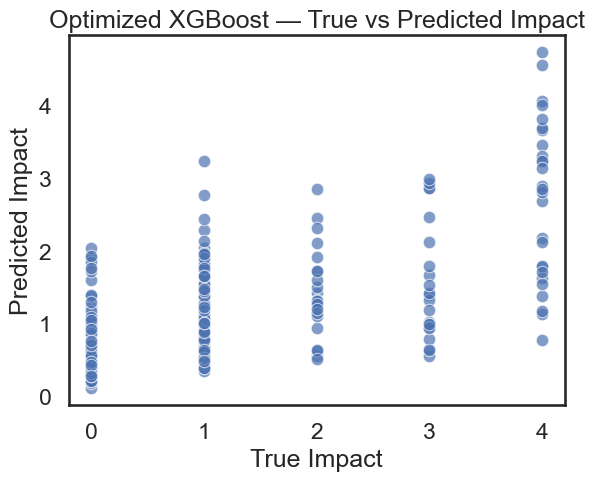

In [28]:
import optuna
from math import sqrt

# build a new train test split with more training data 
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=123, stratify=y.round()
)

# --- define objective function ---
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 500, 2000),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.1, 10.0, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 8),
        "random_state": 123,
        "n_jobs": -1,
        "tree_method": "hist",
    }

    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)

    # Compute RMSE 
    rmse = sqrt(mean_squared_error(y_valid, preds))
    return rmse

# run optimization 
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=80, show_progress_bar=True)

# this step can take some time

# --- best parameters ---
print("Best parameters:", study.best_params)
print("Best RMSE:", study.best_value)

# --- retrain final model ---
best_model = xgb.XGBRegressor(**study.best_params)
best_model.fit(X_train, y_train)

# --- evaluate ---
y_pred = best_model.predict(X_valid)
r2 = r2_score(y_valid, y_pred)
rmse = sqrt(mean_squared_error(y_valid, y_pred))
print(f"Optimized R² = {r2:.3f}, RMSE = {rmse:.3f}")

sns.scatterplot(x=y_valid, y=y_pred, alpha=0.7)
plt.xlabel("True Impact")
plt.ylabel("Predicted Impact")
plt.title("Optimized XGBoost — True vs Predicted Impact")
plt.show()

Weighted R² = 0.386, RMSE = 0.928


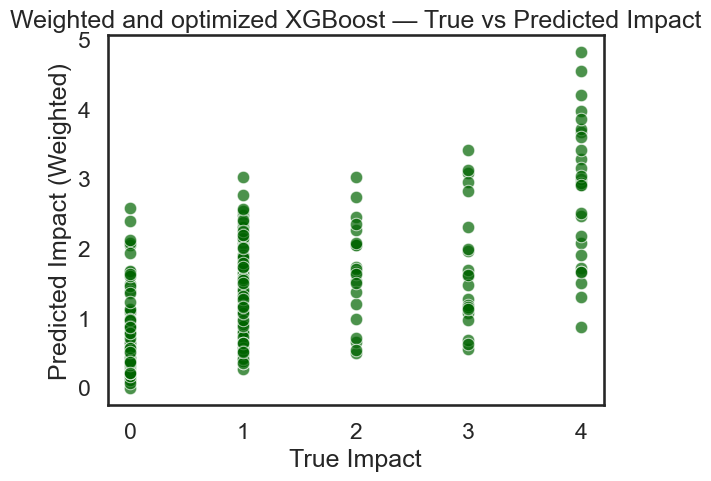

In [31]:
# Weighted refit
weights = y_train.map({0:0.8, 1:0.5, 2:1.5, 3:1.3, 4:1.3})
best_model.fit(X_train, y_train, sample_weight=weights)

# Predict
y_pred_weighted = best_model.predict(X_valid)

# Evaluate
r2_w = r2_score(y_valid, y_pred_weighted)
rmse_w = sqrt(mean_squared_error(y_valid, y_pred_weighted))
print(f"Weighted R² = {r2_w:.3f}, RMSE = {rmse_w:.3f}")
sns.scatterplot(x=y_valid, y=y_pred_weighted, alpha=0.7, color="darkgreen")
plt.xlabel("True Impact")
plt.ylabel("Predicted Impact (Weighted)")
plt.title("Weighted and optimized XGBoost — True vs Predicted Impact")
plt.show()

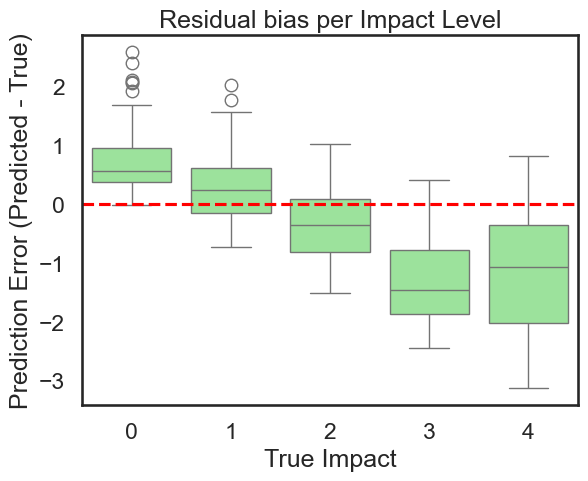

In [ ]:
# little plot to visualize residual bias afer weighting and 
sns.boxplot(x=y_valid, y=y_pred_weighted - y_valid, color="lightgreen")
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("True Impact")
plt.ylabel("Prediction Error (Predicted - True)")
plt.title("Residual bias per Impact Level")
plt.show()

Let's finish by making a feature importance plot

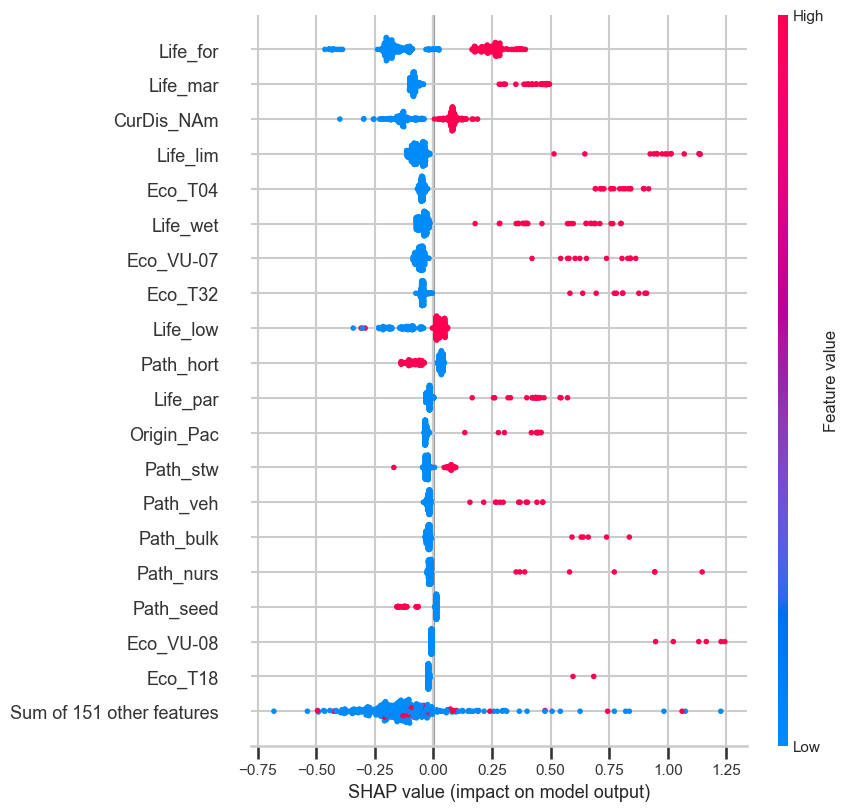

In [ ]:
import shap
explainer = shap.Explainer(best_model) 
shap_values = explainer(X_valid)

shap.plots.beeswarm(shap_values, max_display=20)